In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [6]:
with open('names.txt') as f:
    content = f.read()
    words = content.splitlines()

In [7]:
len(words)

32033

In [396]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i: s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [397]:
import torch

# Context length of how many characters support the prediction. This is consistent with
# the paper we're following
block_size = 3

x, y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        x.append(context)
        y.append(ix)
        #print(''.join(itos[i] for i in context), "--->", ch)
        # Advance the rolling window of context
        context = context[1:] + [ix]


X = torch.tensor(x)
Y = torch.tensor(y)

In [99]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [537]:
# Build dataset splits
def build_dataset(words: list[str], block_size: int) -> (torch.tensor, torch.tensor):
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context), "--->", ch)
            # Advance the rolling window of context
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

CONTEXT_SZ = 3
Xtr, Ytr = build_dataset(words[:n1], CONTEXT_SZ)
Xdev, Ydev = build_dataset(words[n1:n2], CONTEXT_SZ)
Xte, Yte = build_dataset(words[n2:], CONTEXT_SZ)


torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


# Embedding Lookup table

In [399]:
import torch.nn.functional as F

# C is the lookup table which is the first layer of the network
C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [400]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

# Hidden Layer

In [401]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [402]:
# Hidden layer of activations for examples

# torch.concat(emb[:, 0, :], emb[:, 1, :], emb[:, 2, :])
# torch.unbind(emb, 1), 1)
h = torch.tanh(emb.view(-1, 6) @ W1 + b)
h.shape

torch.Size([228146, 100])

# Output layer

In [403]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + B2
logits.shape

torch.Size([228146, 27])

In [342]:
counts = logits.exp()
counts.shape

torch.Size([228146, 27])

In [343]:
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([228146, 27])

# Negative Log Likelihood Loss

In [344]:
# Current probabilities to the correct character in the sequence
loss = -probs[torch.arange(32), Y].log().mean()
loss.item()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [197]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

# Cleaned Up

In [560]:
CONTEXT_SZ = 3
EMBED_SZ = 10
HIDDEN_LAYER_SZ = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, EMBED_SZ), generator=g)
W1 = torch.randn((CONTEXT_SZ * EMBED_SZ, HIDDEN_LAYER_SZ), generator=g)
b1 = torch.randn(HIDDEN_LAYER_SZ, generator=g)
W2 = torch.randn((HIDDEN_LAYER_SZ, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [561]:
# Total number of parameters
sum(p.nelement() for p in parameters)

11897

In [562]:
for p in parameters:
    p.requires_grad = True

In [563]:
# It doesn't make sense to step through the learning rate linearly. Instead, we'll
# step through the exponents linearly.
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10**lre


lri = []
lossi = []
stepi = []

In [564]:
for i in range(200000):
    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # (32)

    # Forward Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    #lri.append(lre[i])
print(loss.item())


1.7834784984588623


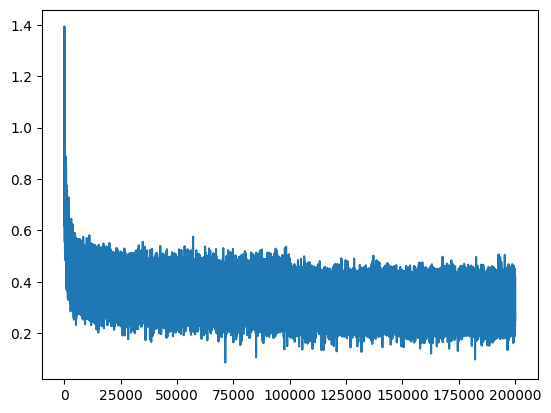

In [565]:
plt.plot(stepi, lossi)

In [568]:
# Loss on training set
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1203317642211914


In [569]:
# Loss on dev set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1747796535491943


In [567]:
# Loss on entire training set
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, CONTEXT_SZ * EMBED_SZ) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.1315622329711914


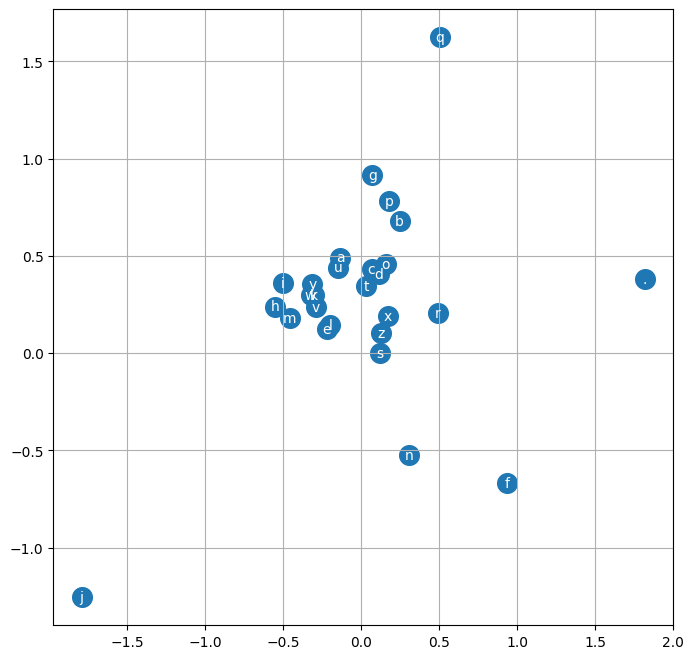

In [570]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Challenge

Knobs available:
- number of neurons in hidden layer
- embedding table size
- numbers of characters as input
- details of optimization
- batch size (convergence speed)

Read the paper, and it also has ideas for improvements.

# Sample from the model

In [574]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * CONTEXT_SZ
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        # Make logits sum to 1
        probs = F.softmax(logits, dim=1)
        # Sample from probabilities
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))


carlah.
amelle.
khy.
mri.
rehildencessa.
jazhutefaverric.
kaeli.
nellara.
chaiim.
kaleigh.
ham.
joce.
quintis.
lilea.
jadiquo.
jerri.
jaryxingtte.
pirrather.
edi.
abette.
